<a href="https://colab.research.google.com/github/lamatechno32844-beep/ai_lmaa/blob/main/V0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***استيراد المكتبات***

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# ***ربط على drive***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***دمج الملفات***

In [ ]:
data1 = pd.read_csv("/content/drive/MyDrive/AI/ai/bd_students_per_v2.csv")
data2 = pd.read_csv("/content/drive/MyDrive/AI/ai/student_performance_dirty.csv")
data2.rename(columns={"Text":"Comment"}, inplace=True)
df = pd.concat([data1, data2], ignore_index=True)

# ***التحقق من وجود بيانات مكررة***

In [ ]:
has_duplicates = df.duplicated().any()
print ("Are there duplicates rows:",has_duplicates)

Are there duplicates rows: True


# ***حساب عدد الصفوف المكررة***

In [ ]:
no_of_duplicates = df.duplicated (). sum()
print("Number of duplicates rows:", no_of_duplicates)

Number of duplicates rows: 44


# ***حذف الصفوف المكررة***

In [ ]:
df = df.drop_duplicates(keep="first")
print(f"Number of rows after removing dupli {df.shape[0]},Number of clums: {df.shape[1]}")

Number of rows after removing dupli 18573,Number of clums: 31


# ***التحقق من القيم المفقودة***

In [ ]:
(df.isnull().sum())

,0
id,9961
full_name,9961
age,9961
gender,9961
location,9962
family_size,9961
mother_education,9971
father_education,9965
mother_job,9961
father_job,9961


# ***معالجة القيم المفقودة***

In [ ]:
#يمر على كل عمود في البيانات عشان يفحصهم
for col in df.columns:
#وهون بشوف هل العمود رقمي او لا
   if df[col].dtype != "object":
      #يستبدل القيمه بالمتوسط تاعها
       df[col].fillna(df[col].mean(), inplace=True)
        #اذا كان نص يوخد القيمه الاكثر تكرار
   else:
       df[col].fillna(df[col].mode()[0], inplace=True)


/tmp/ipython-input-2960459199.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipython-input-2960459199.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

# ***اظهار اسماء الاعمدة ***

In [ ]:
print(df.columns)

Index(['id', 'full_name', 'age', 'gender', 'location', 'family_size',
       'mother_education', 'father_education', 'mother_job', 'father_job',
       'guardian', 'parental_involvement', 'internet_access', 'studytime',
       'tutoring', 'school_type', 'attendance', 'extra_curricular_activities',
       'english', 'math', 'science', 'social_science', 'art_culture',
       'stu_group', 'Hours Studied', 'Previous Scores',
       'Extracurricular Activities', 'Sleep Hours',
       'Sample Question Papers Practiced', 'Performance Index', 'Notes'],
      dtype='object')


# ***حذف الاعمدة الغير مهمة ***

In [ ]:
# حذف أعمدة غير مهمة
df = df.drop(columns=[
   'id',
    'full_name',
    'Notes',
    'guardian',
    'Extracurricular Activities',
    'mother_job',
    'father_job',
    'location',
    'Performance Index'
], errors='ignore')


# ***استكشاف القيم الشاذة***

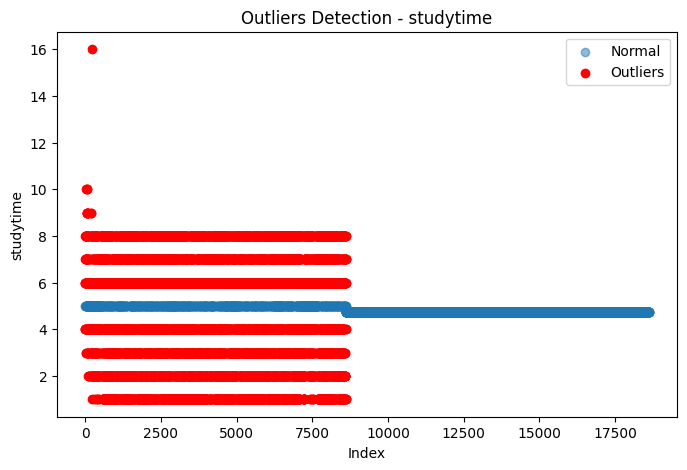

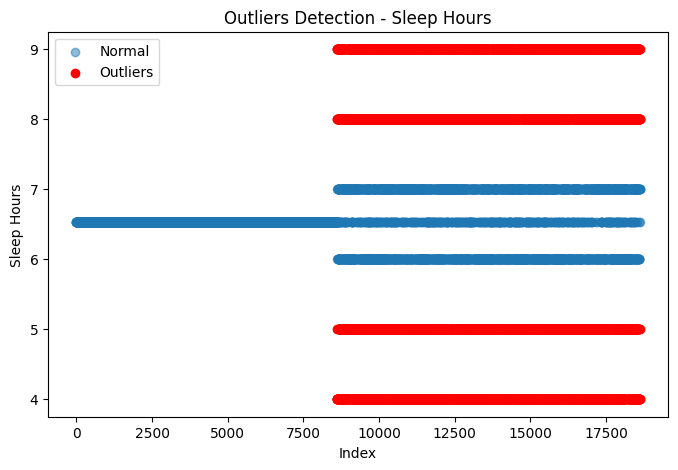

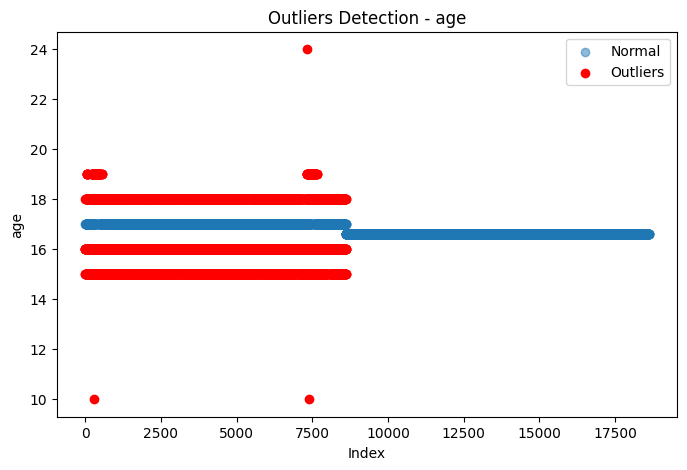

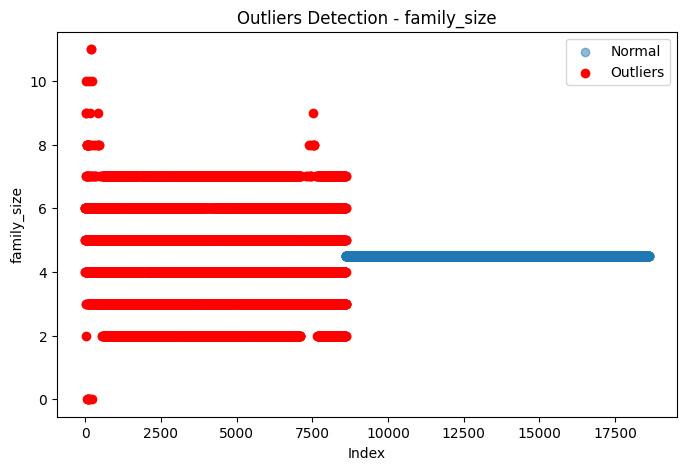

In [ ]:
def plot_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    normal = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    plt.figure(figsize=(8,5))
    plt.scatter(normal.index, normal[column], label="Normal", alpha=0.5)
    plt.scatter(outliers.index, outliers[column], color='red', label="Outliers")

    plt.title(f"Outliers Detection - {column}")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()
    plt.show()

plot_outliers(df, 'studytime')
plot_outliers(df, 'Sleep Hours')
plot_outliers(df, 'age')
plot_outliers(df, 'family_size')

# ***معالجة القيم الشاذة***

In [ ]:
columns_to_clean = ['age', 'family_size', 'studytime','Sleep Hours']

def handle_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median_value = df[column].median()

    # استبدال القيم الشاذة بالوسيط
    df.loc[(df[column] < lower_bound) |
           (df[column] > upper_bound), column] = median_value

    return df

# تطبيق المعالجة فقط على الأعمدة المحددة
for col in columns_to_clean:
    df = handle_outliers_iqr(df, col)

print("تمت معالجة القيم الشاذة ")

تمت معالجة القيم الشاذة 


# ***احصائه للبيانات***

In [ ]:
print(df.describe())

                age   family_size     studytime    attendance       english  \
count  18573.000000  1.857300e+04  18573.000000  18573.000000  18573.000000   
mean      16.686712  4.502206e+00      4.760915     74.027055     73.610427   
std        0.150544  1.200850e-12      0.059379      9.049487     10.448004   
min       16.614375  4.502206e+00      4.746168     30.000000     18.000000   
25%       16.614375  4.502206e+00      4.746168     74.027055     73.610427   
50%       16.614375  4.502206e+00      4.746168     74.027055     73.610427   
75%       16.614375  4.502206e+00      4.746168     74.027055     74.000000   
max       17.000000  4.502206e+00      5.000000    100.000000    100.000000   

               math       science  social_science   art_culture  \
count  18573.000000  18573.000000    18573.000000  18573.000000   
mean      72.938110     73.524036       74.465513     76.236066   
std       10.769565     10.292209       10.176958      9.273564   
min       33.000000 

# ***استكشاف التحيز***

In [ ]:
# حساب نسبة كل فئة
class_percentage = df['gender'].value_counts(normalize=True) * 100

print("نسبة كل فئة (%):")
print(class_percentage)

# نسبة التحيّز = نسبة أكبر فئة
bias_percentage = class_percentage.max()

print("\nنسبة التحيّز في البيانات:")
print(f"{bias_percentage:.2f}%")

نسبة كل فئة (%):
gender
Male      76.982717
Female    23.017283
Name: proportion, dtype: float64

نسبة التحيّز في البيانات:
76.98%


# ***معالجة التحيز***

In [ ]:
# نفصل الذكور والإناث
df_male = df[df['gender'] == 'Male']
df_female = df[df['gender'] == 'Female']

# نعمل Oversampling للإناث
df_female_upsampled = resample(
    df_female,
    replace=True,                 # نسمح بالتكرار
    n_samples=len(df_male),       # نخليهم نفس عدد الذكور
    random_state=42
)

# ندمج البيانات
df_balanced = pd.concat([df_male, df_female_upsampled])

# نخلط البيانات
df_balanced = df_balanced.sample(frac=1, random_state=42)

# نشوف النتيجة
print(df_balanced['gender'].value_counts(normalize=True) * 100)

gender
Male      50.0
Female    50.0
Name: proportion, dtype: float64


# ***استكشاف التحيز***

In [ ]:
# حساب نسبة كل فئة
class_percentage = df['school_type'].value_counts(normalize=True) * 100

print("نسبة كل فئة (%):")
print(class_percentage)

# نسبة التحيّز = نسبة أكبر فئة
bias_percentage = class_percentage.max()

print("\nنسبة التحيّز في البيانات:")
print(f"{bias_percentage:.2f}%")



نسبة كل فئة (%):
school_type
Govt         70.597103
Semi_Govt    16.513218
Private      12.889679
Name: proportion, dtype: float64

نسبة التحيّز في البيانات:
70.60%


# ***معالجة التحيز***

In [ ]:

# نفصل كل فئة
df_gov = df[df['school_type'] == 'Govt']
df_semi = df[df['school_type'] == 'Semi_Govt']
df_private = df[df['school_type'] == 'Private']

# نحدد أكبر حجم (Govt)
max_size = len(df_gov)

# نعمل Upsample للفئات الأقل
df_semi_up = resample(df_semi, replace=True, n_samples=max_size, random_state=42)
df_private_up = resample(df_private, replace=True, n_samples=max_size, random_state=42)

# ندمج
df_balanced = pd.concat([df_gov, df_semi_up, df_private_up])

# نخلط
df_balanced = df_balanced.sample(frac=1, random_state=42)

# نشوف النتيجة
print(df_balanced['school_type'].value_counts(normalize=True) * 100)

school_type
Private      33.333333
Semi_Govt    33.333333
Govt         33.333333
Name: proportion, dtype: float64


# ***تجهيز البيانات وتدريب نموذج Random Forest***

# ***تحويل الأعمدة النصية إلى أرقام***

In [ ]:
# تحويل الأعمدة النصية إلى أرقام
le = LabelEncoder()

for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# ***تحديد X و y***

In [ ]:
# تحديد المتغيرات المستقلة (X) والمتغير الهدف (y)
X = df.drop("stu_group", axis=1)
y = df["stu_group"]

# ***تقسيم البيانات***

In [ ]:
# تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ***إنشاء وتدريب نموذج Random Forest***

In [ ]:
# إنشاء نموذج Random Forest مع موازنة الفئات
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# تدريب النموذج
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

# ***التنبؤ والتقييم***

In [ ]:
# التنبؤ على بيانات الاختبار
y_pred = rf.predict(X_test)

# حساب الدقة
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", round(accuracy,4))

Accuracy: 0.9938


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       583
           1       0.98      0.99      0.98       545
           2       1.00      1.00      1.00      2587

    accuracy                           0.99      3715
   macro avg       0.99      0.99      0.99      3715
weighted avg       0.99      0.99      0.99      3715



# ***تطبيق خوارزمية الانحدار اللوجستي***

# ***تحديد X و y***

In [ ]:
# تحديد المتغيرات المستقلة (X) والمتغير الهدف (y)
X = df.drop("stu_group", axis=1)   # كل الأعمدة ما عدا الهدف
y = df["stu_group"]                # الهدف

# ***تقسيم البيانات***

In [ ]:
# تقسيم البيانات إلى تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ***إنشاء وتدريب النموذج***

In [ ]:
# إنشاء نموذج الانحدار اللوجستي
model = LogisticRegression(max_iter=1000)

# تدريب النموذج
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

# ***التنبؤ وحساب الدقة***

In [ ]:
# التنبؤ على بيانات الاختبار
y_pred = model.predict(X_test)

# حساب الدقة
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", round(accuracy, 4))

Accuracy: 0.9701


# ***رسم Sigmoid Curve***

# ***اختيار الفئات***

In [ ]:
# اختيار فئتين فقط (مثلاً 0 و 1)
df_binary = df[df['stu_group'].isin([0, 1])]

# ***تحديد X و y***

In [ ]:
# اختيار متغير واحد للرسم (math)
X = df_binary[['math']]
y = df_binary['stu_group']

# ***تقسيم البيانات***

In [ ]:
# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ***تدريب النموذج***

In [ ]:
# إنشاء وتدريب نموذج الانحدار اللوجستي
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# ***رسم النتائج***

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


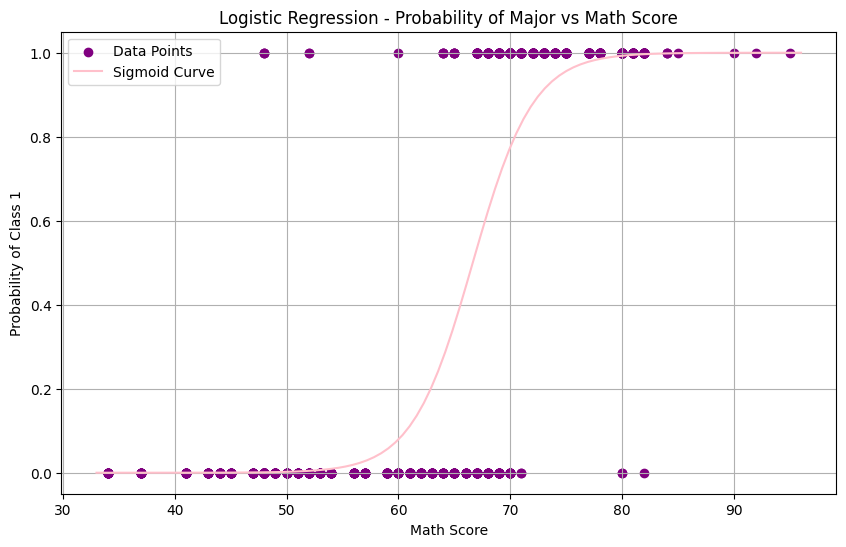

In [ ]:
# رسم نقاط البيانات
plt.figure(figsize=(10,6))
plt.scatter(X_test, y_test, color='purple', label='Data Points')

# رسم منحنى السيغمويد
X_values = np.linspace(X.min(), X.max(), 100).reshape(-1,1)
y_proba = model.predict_proba(X_values)[:,1]

plt.plot(X_values, y_proba, color='pink', label='Sigmoid Curve')

plt.xlabel('Math Score')
plt.ylabel('Probability of Class 1')
plt.title('Logistic Regression - Probability of Major vs Math Score')
plt.legend()
plt.grid(True)
plt.show()

# ***حفظ الموديل***

In [ ]:
import joblib

joblib.dump(rf, "random_forest_model.pkl")

['random_forest_model.pkl']

# ***تحميل الموديل على جهازي***

In [ ]:
from google.colab import files
files.download("random_forest_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df.to_csv('data_filtered.csv', index=False)
print("Cleaned dataset saved as 'data_filtered.csv'")

Cleaned dataset saved as 'data_filtered.csv'
